In [0]:
# This is the code for the multi-label Roberta model. First, we try the pre-packaged multi-label version. If that doesn't work good, implement a model following the guidelines 
# from BERT and https://huggingface.co/transformers/model_doc/roberta.html#robertaforsequenceclassification to setup a model with a rank-loss, possible dropout-layer and a 
# end-layer appropriate to the state of the art of neural network multi-label papers (Zhang, Zhou, etc.)

In [2]:
%%writefile setup.sh

git clone https://github.com/NVIDIA/apex
cd apex
pip install -v --no-cache-dir ./

Writing setup.sh


In [3]:
!sh setup.sh

Cloning into 'apex'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 6629 (delta 27), reused 27 (delta 15), pack-reused 6589
Receiving objects: 100% (6629/6629), 13.72 MiB | 14.35 MiB/s, done.
Resolving deltas: 100% (4409/4409), done.
Created temporary directory: /tmp/pip-ephem-wheel-cache-i7knpgas
Created temporary directory: /tmp/pip-req-tracker-mfv686ba
Created requirements tracker '/tmp/pip-req-tracker-mfv686ba'
Created temporary directory: /tmp/pip-install-c3w_vjmm
Processing /content/apex
  Created temporary directory: /tmp/pip-req-build-bp70blzn
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-mfv686ba'
    Running setup.py (path:/tmp/pip-req-build-bp70blzn/setup.py) egg_info for package from file:///content/apex
    Running command python setup.py egg_info
    torch.__version__  =  1.5.0+cu101
    running egg_info
    creating /tmp/pip-req-build-bp70blzn/pip-

In [4]:
# 0. import all necessary dependencies
print("[RoBERTa-MLL]: Starting model fitting and test-run on the 10 datasets.")
!nvidia-smi

# check if we are on a google COLAB notebook
try:
  import google.colab
  IN_COLAB = True
except:
  print("We are not in a Google COLAB setup, please consider adapting the code!")
  IN_COLAB = False

# load packages according to environment
if IN_COLAB == True:
  import os 
  import sys
  import datetime
  import time 
  from multiprocessing import cpu_count
  # check if transformers available
  if 'transformers' in sys.modules:
    import transformers
  else:
    !pip install transformers
  # check if transformers available
  if 'simpletransformers' in sys.modules:
    import transformers
  else:
    !pip install simpletransformers
  if 'tensorboardX' in sys.modules:
    import tensorboardX
  else:
    !pip install tensorboardX
  # then import everything
  import tensorflow as tf 
  import torch 
  from torch.cuda import memory_allocated
  from torch.cuda import memory_cached
  import transformers
  import simpletransformers 
  from simpletransformers.classification import MultiLabelClassificationModel
  import pandas as pd
  import numpy as np 
  import scipy
  import sklearn 
  from sklearn.metrics import accuracy_score, f1_score, hamming_loss, label_ranking_loss, label_ranking_average_precision_score
  from sklearn.metrics import precision_score, recall_score, zero_one_loss
  from sklearn.model_selection import train_test_split
  import torch 
  import seqeval
  import tensorboardX
  import tqdm
  import logging
  from google.colab import drive
  import matplotlib.pyplot as plt
  from matplotlib import rcParams
  rcParams['font.family'] = 'serif'
  rcParams['font.sans-serif'] = ['Verdana']
else:
  print("Not in COLAB environment!")
print("[RoBERTa-MLL]: basic dependencies loaded")

[RoBERTa-MLL]: Starting model fitting and test-run on the 10 datasets.
Thu Apr 30 09:26:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:     

In [0]:
# 1. define helper functions
def mount_gpu():
  # function for mounting the GPU available on the machine / or notebook
  # first check if we are in the COLAB environment
  try:
    import google.colab
    IN_COLAB = True
  except:
    IN_COLAB = False

  # COLAB code:
  if IN_COLAB==True:
    # get the GPU device name
    device_name = tf.test.gpu_device_name()

    # in COLAB, the device name should look like:
    if device_name == '/device:GPU:0':
      print('Found GPU at: {}'.format(device_name))
    else:
      raise SystemError('GPU device not found')

    # if we find a GPU:
    if torch.cuda.is_available():    
      # swith torch to GPU
      device = torch.device("cuda")
      print('There are {} GPU(s) available.'.format(torch.cuda.device_count()))
      print('We will use the GPU:', torch.cuda.get_device_name(0))
    else:
      # otherwise, we notify the user and switch torch to CPU
      print('No GPU available, using the CPU instead.')
      device = torch.device("cpu")
  else:
    print("No COLAB environment, getting GPU via TF")
    if tf.test.is_gpu_available()==True:
      # swith torch to GPU
      device = torch.device("cuda")
      print('There are %d GPU(s) available.' % torch.cuda.device_count())
      print('Found GPU at: {}'.format(tf.test.gpu_device_name()))
      print('We will use the GPU:', torch.cuda.get_device_name(0))
    else:
      print('No GPU available, using the CPU instead.')
      device = torch.device("cpu")
  # return the mounted device 
  return device

# some self-defined metrics for use with the scikit-learn metrics
def custom_acc(out, labels):
      # as the predictions have to be converted to multi-label 
      # integer-formatted predictions, we have to check each
      # element of the predictions vector across a threshold to 
      # generate the binary label markers (we use 0.5 as a threshold
      # here) - then we have to check the new vector against 
      # the ground truth and calculate the accuracy
      tmp_input = out 
      # set all vector elements >0.5 to 1, all below to 0
      tmp_input[tmp_input>0.5] = 1
      tmp_input[tmp_input<0.5] = 0
      # then calculate the accuracy against ground truth
      pred_flat = tmp_input.flatten()
      labels_flat = labels.flatten()
      count_true = np.sum(pred_flat == labels_flat)
      acc_int = count_true / len(labels_flat)
      # crosscheck
      acc_scikit = accuracy_score(pred_flat, labels_flat)
      print("Accuracy self: {} vs. scikit: {}, check: {}".format(acc_int, acc_scikit, (acc_scikit==acc_int)))
      return acc_int

def f1_row_cardsmith(y_test_true, y_test_pred):
    """Calculates a row-wise / observations - based F1 Score just like in the paper by Card/Smith 2015.
    Takes in the test-dataframe containing the ground truth in binary vectors and the predictions-dataframe
    containing the predicted binary vectors for all test observations. These have to be provided as dataframes
    containing only zeros or ones. Returns a scalar value / the F1 score
  	as calculated by Card/Smith, p. 4 (formula 1).

    :param y_test_true: dataframe containing the ground truth binary code vectors
    :param y_test_pred: dataframe containing the predicted binary code vectors
    :return: scalar, the F1 Score as calculated by Card/Smith, Formula 1, page 4
    """
    # now calculate the f1 score row wise by using the formula from card / smith
    y_test_true = pd.DataFrame.from_records(y_test_true)
    f1_sum = 0
    for index, row in y_test_pred.iterrows():
        # extract the original binary code vector from y_test (ground truth)
        ground_truth = y_test_true.iloc[index, :]
        # extract the predicted binary code vector from df_results (prediction)
        predvec = row
        # calculate the counter (dot vector product between ground truth and predvec)
        above = np.asscalar(np.dot(ground_truth, predvec))
        # calculate the denominator (1-norm of ground truth and predvec)
        denom = np.asscalar(np.linalg.norm(ground_truth, ord=1) + np.linalg.norm(predvec, ord=1))
        # calculate the pre-score and build up the sum
        try:  # might encounter division by zero!
            pre_score = (2 * (above / denom))
        except ZeroDivisionError:
            pre_score = 0  # set to zero, if denominator is 0!
        # aggregate the individual F1-values up
        f1_sum += pre_score
    # get number of rows in test set
    nrow = y_test_true.shape[0]
    # calculate the final, row-wise score
    f1_final = f1_sum / nrow
    return f1_final

# 2. Main model function
def roberta_multilabel_classification(dataset_filenamelist, roberta_config, dump_pred_path, verbose=False):
  """ Reads in a list of dataset filenames, loads them, pre-processes them for Roberta and then fine-tunes a RoBERTa Model on the
      current dataset. Generates either visual display of all metrics during training and testing (all_metrics=TRUE)
      or suppresses this output. Returns test_f1_macro, test_f1_micro, test_precision_macro, test_precision_micro, 
      test_recall_macro, test_recall_micro, test_acc_score, test_hamloss, test_f1_samples, test_cardsmith, test_rankloss,
      test_LRAP after the final evaluation run."""
  print("=====================================================================")
  # 1. perform some input - checks and mount gpu 
  current_gpu = mount_gpu()

  if dataset_filenamelist is None or len(dataset_filenamelist)==0:
    print("[RoBERTa-MLL]: No filename-list given for the fixed train/test splits - aborting!")
    return

  if roberta_config is None:
    print("[RoBERTa-MLL]: No RoBERTa-Model configuration given - aborting!")
    return

  if dump_pred_path is None or len(dataset_filenamelist)==0:
    print("[RoBERTa-MLL]: No folder is given for the predictions dumps - aborting!")
    return

  # 2. shoot off Status message and timestamp
  print("[RoBERTa-MLL]: Started multi-label classification on {} at: {}".
        format(dataset_filenamelist, datetime.datetime.now()))

  # 3. load dataset parts
  get_xtrainp=dataset_filenamelist[0]
  get_xtestp=dataset_filenamelist[1]
  get_ytrainp=dataset_filenamelist[2]
  get_ytestp=dataset_filenamelist[3]
  X_train_raw=pd.read_csv(get_xtrainp, sep = ',', encoding='utf-8')
  X_test_raw=pd.read_csv(get_xtestp, sep = ',', encoding='utf-8')
  y_train_raw=pd.read_csv(get_ytrainp, sep = ',', encoding='utf-8')
  y_test_raw=pd.read_csv(get_ytestp, sep = ',', encoding='utf-8')

  # get test data portion labels as numpy ndarray from dataframe
  y_test = y_test_raw.to_numpy(dtype=int)
  
  if verbose==True:
    print("[RoBERTa-MLL]: Xtrain dataset {} head: \n {}".format(get_xtrainp, 
                                                        X_train_raw.head()))
    print("[RoBERTa-MLL]: Xtest dataset {} head: \n {}".format(get_xtestp, 
                                                          X_test_raw.head()))
    print("[RoBERTa-MLL]: ytrain dataset {} head: \n {}".format(get_ytrainp, 
                                                          y_train_raw.head()))
    print("[RoBERTa-MLL]: ytest dataset {} head: \n {}".format(get_ytestp, 
                                                          y_test_raw.head()))
    
  # get category indices and number of categories present in dataset for later
  categories=y_train_raw.columns.values.tolist()
  num_labels_df, pred_final_colsize=len(categories), len(categories)

  # print some overview statistics 
  if verbose == True:
    print("[RoBERTa-MLL]: Word count train: ", X_train_raw['verbatim'].apply(lambda x: len(x.split(' '))).sum())
    print("[RoBERTa-MLL]: Word count test: ", X_test_raw['verbatim'].apply(lambda x: len(x.split(' '))).sum())
    print("[RoBERTa-MLL]: Labels of the dataset: \n", categories, " count: ", len(categories))
    print("[RoBERTa-MLL]: Number of overall training verbatims: {:,}\n".format(X_train_raw.shape[0]))
    print("[RoBERTa-MLL]: Number of overall testing verbatims: {:,}\n".format(X_test_raw.shape[0]))

  # 4. perform RoBERTa - specific preprocessing

  # RoBERTa requires all text to be in column "text" and all labels as a list in
  # column "labels", hence we have to collect the labels into lists for train/test

  # Train data portion
  # print("Column count y_train_raw: ", y_train_raw.shape[1])
  # get all labels from one observation, create a list and store
  train_observations_labels = []
  for index, row in y_train_raw.iterrows():
      # get raw row values as a list
      get_raw = row.values
      labels_list = list(tuple(get_raw))
      # labels_list = row.values.tolist()
      # print(labels_list, " / ", "type: ", str(type(labels_list)))
      train_observations_labels.append(labels_list)
  # init list of labels column
  y_train_raw['label_list'] = train_observations_labels  
  # quick inspect it, having a look on the results for plausibility
  if verbose == True:
    print(y_train_raw.head())
    print(y_train_raw.tail())
  # generate new training data df, using X_train_raw
  X_train_raw['labels'] = train_observations_labels
  X_train_raw['text'] = X_train_raw['verbatim']
  # copy text and label into !one! dataframe
  X_train_roberta = X_train_raw[['caseID', 'text', 'labels']]

  # Test data portion
  # print("Column count y_test_raw: ", y_test_raw.shape[1])
  # get all labels from one observation, create a list and store
  test_observations_labels = []
  for index, row in y_test_raw.iterrows():
      # get raw row values as a list
      get_raw = row.values
      labels_list = list(tuple(get_raw))
      # labels_list = row.values.tolist()
      # print(labels_list, " / ", "type: ", str(type(labels_list)))
      test_observations_labels.append(labels_list)
  # init list of labels column
  y_test_raw['label_list'] = test_observations_labels  
  # quick inspect it, having a look on the results for plausibility
  if verbose == True:  
    print(y_test_raw.head())
    print(y_test_raw.tail())
  # generate new training data df, using X_train_raw
  X_test_raw['labels'] = test_observations_labels
  X_test_raw['text'] = X_test_raw['verbatim']
  # copy text and label into !one! dataframe
  X_test_roberta = X_test_raw[['caseID', 'text', 'labels']]

  # 5. Generate a training evaluation data portion from the train data set
  train_df, eval_df = train_test_split(X_train_roberta, test_size=0.1)
  # non-conformity regarding multi label stratified splitting, TODO: report in text!

  print("[RoBERTa-MLL]: Trying to set up the model")
  # 5. set the model up for the current number of labels in the dataset
  model_starttime = time.time() # take the time for fitting and predicting
  roberta_model = MultiLabelClassificationModel('roberta', 'roberta-base', 
                                                num_labels=num_labels_df, 
                                                args=roberta_config)
  print("[RoBERTa-MLL]: Successfully setup the model")
  
  # 6. train the model: pass training portion and evaluation portion
  roberta_model.train_model(train_df=train_df, eval_df=eval_df)
  print("[RoBERTa-MLL]: Successfully trained the model")

  # 7. evaluate the model 
  print("[RoBERTa-MLL]: Model evaluation cycle!")
  result, model_outputs, wrong_predictions = roberta_model.eval_model(X_test_roberta)
  print("[RoBERTa-MLL]: Evaluation of the model (LRAP): " + str(result))

  # stop the time here and calculate the elapsed time
  model_stoptime = time.time()
  mod_elapsed_time = model_stoptime - model_starttime
  print("[RoBERTa-MLL]: Time elapsed: {} (in seconds)".format(mod_elapsed_time))
  # use the model outputs to construct a evaluation dataframe 
  # and a evaluation array (don't forget to cross check the outputs)
  # and use a tresholder!

  print("Model outputs type: \n", type(model_outputs))

  # generate a list holding all predictions for the test data
  y_preds = []
  # fill with predictions and convert the predictions to zero / one
  for index in range(len(model_outputs)): 
    # get predictions for each observation
    row = model_outputs[index]
    tmp_input = row
    # set all vector elements >0.5 to 1, all below to 0
    tmp_input[tmp_input>0.5] = 1
    tmp_input[tmp_input<0.5] = 0
    # append to final array
    y_preds.append(tmp_input)
  # convert list to ndarray
  y_predicted = np.asarray(y_preds, dtype=int)
  # store the predictions on HDD for later inspection - as csv file
  fname_wout_extension = os.path.splitext(os.path.basename(get_xtestp))[0]
  dump_path = dump_pred_path + fname_wout_extension + '_RoBERTa_MLL_prediction.csv'
  print("[RoBERTa-MLL]: Current dump_path for predictions: ", dump_path)
  np.savetxt(dump_path, y_predicted, delimiter=',')

  # also keep a copy of the raw outputs (for the rank-based metrics)
  y_score = model_outputs
  

  # 8. calculate performance metrics
  # label based
  test_f1_macro = f1_score(y_test, y_predicted, average='macro')
  test_f1_micro = f1_score(y_test, y_predicted, average='micro')

  test_precision_macro = precision_score(y_test, y_predicted, average='macro')
  test_precision_micro = precision_score(y_test, y_predicted, average='micro')
  test_recall_macro = recall_score(y_test, y_predicted, average='macro')
  test_recall_micro = recall_score(y_test, y_predicted, average='micro')

  # observation based
  test_acc_score = accuracy_score(y_test, y_predicted)
  test_hamloss = hamming_loss(y_test, y_predicted)
  test_f1_samples = f1_score(y_test, y_predicted, average='samples')

  # addition: 0/1 loss 
  test_zero_one_loss = zero_one_loss(y_test, y_predicted)

  # generate a dataframe from the predictions ndarray for the
  # card/smith f1 function
  ypred_df = pd.DataFrame.from_records(y_predicted)
  test_cardsmith = f1_row_cardsmith(y_test, ypred_df)

  # rank based
  test_rankloss = label_ranking_loss(y_test, y_score)
  test_LRAP = label_ranking_average_precision_score(y_test, y_score)
  model_LRAP = result

  if verbose == True:
    # cross check the model - calculated LRAP and our LRAP
    print("Model {} and scikit {} LRAP match: {}".format(test_LRAP, model_LRAP,
                                                       test_LRAP == model_LRAP))

  # 8. build a evaluation metric list
  ret_list = [test_f1_macro, test_f1_micro, test_precision_macro, 
              test_precision_micro, test_recall_macro, test_recall_micro, 
              test_acc_score, test_zero_one_loss, test_hamloss, 
              test_f1_samples, test_cardsmith, test_rankloss, test_LRAP, 
              mod_elapsed_time]

  # 9. shoot off Status message and timestamp
  print("[RoBERTa-MLL]: Finished multi-label classification on {} at: {}".
        format(dataset_filenamelist, datetime.datetime.now()))
  print("=====================================================================")
  print("---------------------------------------------------------------------")
  # 10. finally delete the model and all data to free memory from gpu 
  print("Trying to free the GPU memory by deleting current model and tensors!")
  c = memory_cached(current_gpu)
  a = memory_allocated(current_gpu)
  get_summary = c-a  # free inside cache
  print(f"Memory free inside cache before: {get_summary}")
  del roberta_model
  del result, model_outputs, wrong_predictions
  torch.cuda.empty_cache()
  c = memory_cached(current_gpu)
  a = memory_allocated(current_gpu)
  get_summary = c-a  # free inside cache
  print(f"Memory free inside cache after: {get_summary}")
  print("=====================================================================")
  # 11. return this to the user
  return ret_list

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
[RoBERTa-MLL]: Saving model to: /content/drive/My Drive/ma_data/stored_models/roberta_mll/model_dataset_1/ after fine-tuning!
Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla T4
[RoBERTa-MLL]: Started multi-label classification on ['/content/drive/My Drive/ma_data/dataset1_Xtrain.csv', '/content/drive/My Drive/ma_data/dataset1_Xtest.csv', '/content/drive/My Drive/ma_data/dataset1_ytrain.csv', '/content/drive/My Drive/ma_data


[RoBERTa-MLL]: Successfully setup the model



Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Running loss: 0.689707

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:114: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running loss: 0.661074


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running loss: 0.579120


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running loss: 0.545319

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.369193


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)



[RoBERTa-MLL]: Successfully trained the model
[RoBERTa-MLL]: Model evaluation cycle!



[RoBERTa-MLL]: Evaluation of the model (LRAP): {'LRAP': 0.3574391419347313, 'eval_loss': 0.36990534514188766}
[RoBERTa-MLL]: Time elapsed: 292.73487615585327 (in seconds)
Model outputs type: 
 <class 'numpy.ndarray'>
[RoBERTa-MLL]: Current dump_path for predictions:  /content/drive/My Drive/ma_data/stored_models/roberta_mll/dumped_predictions/dataset1_Xtest_RoBERTa_MLL_prediction.csv


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarnin

[RoBERTa-MLL]: Finished multi-label classification on ['/content/drive/My Drive/ma_data/dataset1_Xtrain.csv', '/content/drive/My Drive/ma_data/dataset1_Xtest.csv', '/content/drive/My Drive/ma_data/dataset1_ytrain.csv', '/content/drive/My Drive/ma_data/dataset1_ytest.csv'] at: 2020-04-30 09:33:01.381958
---------------------------------------------------------------------
Trying to free the GPU memory by deleting current model and tensors!
Memory free inside cache before: 1558175232
Memory free inside cache after: 624942592
Current metrics: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.09259259259259259, 0.0, 0.0, 1.0, 0.09259259259259256, 292.73487615585327]
[RoBERTa-MLL]: Saving model to: /content/drive/My Drive/ma_data/stored_models/roberta_mll/model_dataset_2/ after fine-tuning!
Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla T4
[RoBERTa-MLL]: Started multi-label classification on ['/content/drive/My Drive/ma_data/dataset2_Xtrain.csv', '/content/dri


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Running loss: 0.713363

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:114: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running loss: 0.684845


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running loss: 0.606266

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.478557


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running loss: 0.301914


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)



[RoBERTa-MLL]: Successfully trained the model
[RoBERTa-MLL]: Model evaluation cycle!



[RoBERTa-MLL]: Evaluation of the model (LRAP): {'LRAP': 0.40741936866691764, 'eval_loss': 0.31990353018045425}
[RoBERTa-MLL]: Time elapsed: 284.22263741493225 (in seconds)
Model outputs type: 
 <class 'numpy.ndarray'>
[RoBERTa-MLL]: Current dump_path for predictions:  /content/drive/My Drive/ma_data/stored_models/roberta_mll/dumped_predictions/dataset2_Xtest_RoBERTa_MLL_prediction.csv
[RoBERTa-MLL]: Finished multi-label classification on ['/content/drive/My Drive/ma_data/dataset2_Xtrain.csv', '/content/drive/My Drive/ma_data/dataset2_Xtest.csv', '/content/drive/My Drive/ma_data/dataset2_ytrain.csv', '/content/drive/My Drive/ma_data/dataset2_ytest.csv'] at: 2020-04-30 09:37:48.113262
---------------------------------------------------------------------
Trying to free the GPU memory by deleting current model and tensors!
Memory free inside cache before: 1459033088


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarnin

Memory free inside cache after: 511120384
Current metrics: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.08505747126436781, 0.0, 0.0, 1.0, 0.08505747126436781, 284.22263741493225]
[RoBERTa-MLL]: Saving model to: /content/drive/My Drive/ma_data/stored_models/roberta_mll/model_dataset_3/ after fine-tuning!
Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla T4
[RoBERTa-MLL]: Started multi-label classification on ['/content/drive/My Drive/ma_data/dataset3_Xtrain.csv', '/content/drive/My Drive/ma_data/dataset3_Xtest.csv', '/content/drive/My Drive/ma_data/dataset3_ytrain.csv', '/content/drive/My Drive/ma_data/dataset3_ytest.csv'] at: 2020-04-30 09:37:48.207707
[RoBERTa-MLL]: Trying to set up the model
[RoBERTa-MLL]: Successfully setup the model



Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Running loss: 0.686095

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:114: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running loss: 0.617390

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.227877


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running loss: 0.187466

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.091755


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running loss: 0.083637

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.052378


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)



[RoBERTa-MLL]: Successfully trained the model
[RoBERTa-MLL]: Model evaluation cycle!



[RoBERTa-MLL]: Evaluation of the model (LRAP): {'LRAP': 0.7597357958126351, 'eval_loss': 0.140590827579477}
[RoBERTa-MLL]: Time elapsed: 475.93540263175964 (in seconds)
Model outputs type: 
 <class 'numpy.ndarray'>
[RoBERTa-MLL]: Current dump_path for predictions:  /content/drive/My Drive/ma_data/stored_models/roberta_mll/dumped_predictions/dataset3_Xtest_RoBERTa_MLL_prediction.csv


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: DeprecationWarning: np.asscalar(a) i

[RoBERTa-MLL]: Finished multi-label classification on ['/content/drive/My Drive/ma_data/dataset3_Xtrain.csv', '/content/drive/My Drive/ma_data/dataset3_Xtest.csv', '/content/drive/My Drive/ma_data/dataset3_ytrain.csv', '/content/drive/My Drive/ma_data/dataset3_ytest.csv'] at: 2020-04-30 09:45:48.485995
---------------------------------------------------------------------
Trying to free the GPU memory by deleting current model and tensors!
Memory free inside cache before: 1518466560
Memory free inside cache after: 369227264
Current metrics: [0.18020366184300368, 0.599880739415623, 0.28088872542439597, 0.823240589198036, 0.15738047966073332, 0.4718574108818011, 0.2202247191011236, 0.7797752808988764, 0.045692883895131084, 0.5639519594013976, 0.5639519594013971, 0.5030236139492346, 0.507580094686837, 475.93540263175964]
[RoBERTa-MLL]: Saving model to: /content/drive/My Drive/ma_data/stored_models/roberta_mll/model_dataset_4/ after fine-tuning!
Found GPU at: /device:GPU:0
There are 1 GPU(s


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Running loss: 0.695182

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:114: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running loss: 0.588226

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.154310


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running loss: 0.202198

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.101256


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running loss: 0.098737

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.066044


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)



[RoBERTa-MLL]: Successfully trained the model
[RoBERTa-MLL]: Model evaluation cycle!



[RoBERTa-MLL]: Evaluation of the model (LRAP): {'LRAP': 0.7459335894416178, 'eval_loss': 0.15278722748893206}
[RoBERTa-MLL]: Time elapsed: 505.9601616859436 (in seconds)
Model outputs type: 
 <class 'numpy.ndarray'>
[RoBERTa-MLL]: Current dump_path for predictions:  /content/drive/My Drive/ma_data/stored_models/roberta_mll/dumped_predictions/dataset4_Xtest_RoBERTa_MLL_prediction.csv


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: DeprecationWarning: np.asscalar(a) i

[RoBERTa-MLL]: Finished multi-label classification on ['/content/drive/My Drive/ma_data/dataset4_Xtrain.csv', '/content/drive/My Drive/ma_data/dataset4_Xtest.csv', '/content/drive/My Drive/ma_data/dataset4_ytrain.csv', '/content/drive/My Drive/ma_data/dataset4_ytest.csv'] at: 2020-04-30 09:54:19.465029
---------------------------------------------------------------------
Trying to free the GPU memory by deleting current model and tensors!
Memory free inside cache before: 2526361088
Memory free inside cache after: 1157234176
Current metrics: [0.25908883159272583, 0.5982819605861547, 0.393549759066061, 0.8131868131868132, 0.2240583016069353, 0.47322142286171065, 0.1970954356846473, 0.8029045643153527, 0.048511105687088114, 0.5549865418122679, 0.5549865418122676, 0.5139862761663466, 0.49155661711434373, 505.9601616859436]
[RoBERTa-MLL]: Saving model to: /content/drive/My Drive/ma_data/stored_models/roberta_mll/model_dataset_5/ after fine-tuning!
Found GPU at: /device:GPU:0
There are 1 GPU


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Running loss: 0.704346

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:114: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running loss: 0.585740

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.608538


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running loss: 0.238870

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.076920


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running loss: 0.139605

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.065432


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)



[RoBERTa-MLL]: Successfully trained the model
[RoBERTa-MLL]: Model evaluation cycle!



[RoBERTa-MLL]: Evaluation of the model (LRAP): {'LRAP': 0.7904194153600808, 'eval_loss': 0.16357691299456817}
[RoBERTa-MLL]: Time elapsed: 364.9513521194458 (in seconds)
Model outputs type: 
 <class 'numpy.ndarray'>
[RoBERTa-MLL]: Current dump_path for predictions:  /content/drive/My Drive/ma_data/stored_models/roberta_mll/dumped_predictions/dataset5_Xtest_RoBERTa_MLL_prediction.csv


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


[RoBERTa-MLL]: Finished multi-label classification on ['/content/drive/My Drive/ma_data/dataset5_Xtrain.csv', '/content/drive/My Drive/ma_data/dataset5_Xtest.csv', '/content/drive/My Drive/ma_data/dataset5_ytrain.csv', '/content/drive/My Drive/ma_data/dataset5_ytest.csv'] at: 2020-04-30 10:00:28.153221
---------------------------------------------------------------------
Trying to free the GPU memory by deleting current model and tensors!
Memory free inside cache before: 2526497280
Memory free inside cache after: 1163530752
Current metrics: [0.20820432985639495, 0.6217948717948717, 0.2992721564150136, 0.9556650246305419, 0.18575208175577096, 0.46080760095011875, 0.3170731707317073, 0.6829268292682926, 0.04427767354596623, 0.5733526906697638, 0.5733526906697641, 0.4918999646518204, 0.5471535781291873, 364.9513521194458]
[RoBERTa-MLL]: Saving model to: /content/drive/My Drive/ma_data/stored_models/roberta_mll/model_dataset_6/ after fine-tuning!
Found GPU at: /device:GPU:0
There are 1 GPU


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Running loss: 0.695861

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:114: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running loss: 0.610555

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.055428


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running loss: 0.047170

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.029517


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running loss: 0.053111

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.043641

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running loss: 0.013549

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.025262


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)



[RoBERTa-MLL]: Successfully trained the model
[RoBERTa-MLL]: Model evaluation cycle!



[RoBERTa-MLL]: Evaluation of the model (LRAP): {'LRAP': 0.9327995409875486, 'eval_loss': 0.03738631465687202}
[RoBERTa-MLL]: Time elapsed: 870.6368136405945 (in seconds)
Model outputs type: 
 <class 'numpy.ndarray'>
[RoBERTa-MLL]: Current dump_path for predictions:  /content/drive/My Drive/ma_data/stored_models/roberta_mll/dumped_predictions/dataset6_Xtest_RoBERTa_MLL_prediction.csv


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: DeprecationWarning: np.asscalar(a) i

[RoBERTa-MLL]: Finished multi-label classification on ['/content/drive/My Drive/ma_data/dataset6_Xtrain.csv', '/content/drive/My Drive/ma_data/dataset6_Xtest.csv', '/content/drive/My Drive/ma_data/dataset6_ytrain.csv', '/content/drive/My Drive/ma_data/dataset6_ytest.csv'] at: 2020-04-30 10:15:04.142416
---------------------------------------------------------------------
Trying to free the GPU memory by deleting current model and tensors!
Memory free inside cache before: 2579757568
Memory free inside cache after: 1111933440
Current metrics: [0.13944305606402305, 0.8522959929804037, 0.21403380699985908, 0.9931833674164963, 0.1280514589944015, 0.7464139344262295, 0.5409638554216868, 0.4590361445783132, 0.008450468540829986, 0.8502925989672977, 0.8502925989672935, 0.2176165764109448, 0.7879847963281733, 870.6368136405945]
[RoBERTa-MLL]: Saving model to: /content/drive/My Drive/ma_data/stored_models/roberta_mll/model_dataset_7/ after fine-tuning!
Found GPU at: /device:GPU:0
There are 1 GPU


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Running loss: 0.674855

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:114: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running loss: 0.552892

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.143366Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Running loss: 0.065107


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running loss: 0.048965

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.028479


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running loss: 0.061082

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.029368


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)



[RoBERTa-MLL]: Successfully trained the model
[RoBERTa-MLL]: Model evaluation cycle!



[RoBERTa-MLL]: Evaluation of the model (LRAP): {'LRAP': 0.978918650793651, 'eval_loss': 0.0616012833869228}
[RoBERTa-MLL]: Time elapsed: 385.1890199184418 (in seconds)
Model outputs type: 
 <class 'numpy.ndarray'>
[RoBERTa-MLL]: Current dump_path for predictions:  /content/drive/My Drive/ma_data/stored_models/roberta_mll/dumped_predictions/dataset7_Xtest_RoBERTa_MLL_prediction.csv


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


[RoBERTa-MLL]: Finished multi-label classification on ['/content/drive/My Drive/ma_data/dataset7_Xtrain.csv', '/content/drive/My Drive/ma_data/dataset7_Xtest.csv', '/content/drive/My Drive/ma_data/dataset7_ytrain.csv', '/content/drive/My Drive/ma_data/dataset7_ytest.csv'] at: 2020-04-30 10:21:31.947162
---------------------------------------------------------------------
Trying to free the GPU memory by deleting current model and tensors!
Memory free inside cache before: 2520517632
Memory free inside cache after: 1119802368
Current metrics: [0.5112104757404575, 0.9562171628721541, 0.5112707789887095, 0.9646643109540636, 0.5151004304160689, 0.9479166666666666, 0.9134615384615384, 0.08653846153846156, 0.013354700854700854, 0.9520833333333333, 0.9520833333333332, 0.052503052503052504, 0.9496527777777779, 385.1890199184418]
[RoBERTa-MLL]: Saving model to: /content/drive/My Drive/ma_data/stored_models/roberta_mll/model_dataset_8/ after fine-tuning!
Found GPU at: /device:GPU:0
There are 1 GP


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Running loss: 0.724368

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:114: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running loss: 0.636680

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.059132


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running loss: 0.087714

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.032166


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running loss: 0.079635

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.013541


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)



[RoBERTa-MLL]: Successfully trained the model
[RoBERTa-MLL]: Model evaluation cycle!



[RoBERTa-MLL]: Evaluation of the model (LRAP): {'LRAP': 0.9861769352290678, 'eval_loss': 0.05085477867612132}
[RoBERTa-MLL]: Time elapsed: 384.75937843322754 (in seconds)
Model outputs type: 
 <class 'numpy.ndarray'>
[RoBERTa-MLL]: Current dump_path for predictions:  /content/drive/My Drive/ma_data/stored_models/roberta_mll/dumped_predictions/dataset8_Xtest_RoBERTa_MLL_prediction.csv


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: DeprecationWarning: np.asscalar(a) i

[RoBERTa-MLL]: Finished multi-label classification on ['/content/drive/My Drive/ma_data/dataset8_Xtrain.csv', '/content/drive/My Drive/ma_data/dataset8_Xtest.csv', '/content/drive/My Drive/ma_data/dataset8_ytrain.csv', '/content/drive/My Drive/ma_data/dataset8_ytest.csv'] at: 2020-04-30 10:27:59.940304
---------------------------------------------------------------------
Trying to free the GPU memory by deleting current model and tensors!
Memory free inside cache before: 2481971712
Memory free inside cache after: 1165011456
Current metrics: [0.5131114754379791, 0.967871485943775, 0.5333333333333333, 0.9796747967479674, 0.4997029114676174, 0.9563492063492064, 0.9383886255924171, 0.06161137440758291, 0.006893580353295993, 0.9742496050552922, 0.9742496050552922, 0.030489731437598734, 0.9703791469194313, 384.75937843322754]
[RoBERTa-MLL]: Saving model to: /content/drive/My Drive/ma_data/stored_models/roberta_mll/model_dataset_9/ after fine-tuning!
Found GPU at: /device:GPU:0
There are 1 GP


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Running loss: 0.699651

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:114: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running loss: 0.493565

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.083165


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running loss: 0.086938

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.109473


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running loss: 0.056470

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.064131


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)



[RoBERTa-MLL]: Successfully trained the model
[RoBERTa-MLL]: Model evaluation cycle!



[RoBERTa-MLL]: Evaluation of the model (LRAP): {'LRAP': 0.9698312933678787, 'eval_loss': 0.07108849967614962}
[RoBERTa-MLL]: Time elapsed: 390.5040068626404 (in seconds)
Model outputs type: 
 <class 'numpy.ndarray'>
[RoBERTa-MLL]: Current dump_path for predictions:  /content/drive/My Drive/ma_data/stored_models/roberta_mll/dumped_predictions/dataset9_Xtest_RoBERTa_MLL_prediction.csv


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: DeprecationWarning: np.asscalar(a) i

[RoBERTa-MLL]: Finished multi-label classification on ['/content/drive/My Drive/ma_data/dataset9_Xtrain.csv', '/content/drive/My Drive/ma_data/dataset9_Xtest.csv', '/content/drive/My Drive/ma_data/dataset9_ytrain.csv', '/content/drive/My Drive/ma_data/dataset9_ytest.csv'] at: 2020-04-30 10:34:33.067947
---------------------------------------------------------------------
Trying to free the GPU memory by deleting current model and tensors!
Memory free inside cache before: 2585091584
Memory free inside cache after: 1138238976
Current metrics: [0.43809230371755364, 0.9401088929219601, 0.4911647351248192, 0.9810606060606061, 0.40940628526017525, 0.9024390243902439, 0.8731707317073171, 0.12682926829268293, 0.011498257839721254, 0.9331707317073171, 0.933170731707317, 0.0791019955654102, 0.9269647696476967, 390.5040068626404]
[RoBERTa-MLL]: Saving model to: /content/drive/My Drive/ma_data/stored_models/roberta_mll/model_dataset_10/ after fine-tuning!
Found GPU at: /device:GPU:0
There are 1 GP


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Running loss: 0.715243

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:114: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running loss: 0.547333

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.103353


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running loss: 0.050002

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.023610


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running loss: 0.032000

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.144826


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)



[RoBERTa-MLL]: Successfully trained the model
[RoBERTa-MLL]: Model evaluation cycle!



[RoBERTa-MLL]: Evaluation of the model (LRAP): {'LRAP': 0.9765576323987538, 'eval_loss': 0.06629689286152522}
[RoBERTa-MLL]: Time elapsed: 394.0138247013092 (in seconds)
Model outputs type: 
 <class 'numpy.ndarray'>
[RoBERTa-MLL]: Current dump_path for predictions:  /content/drive/My Drive/ma_data/stored_models/roberta_mll/dumped_predictions/dataset10_Xtest_RoBERTa_MLL_prediction.csv


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


[RoBERTa-MLL]: Finished multi-label classification on ['/content/drive/My Drive/ma_data/dataset10_Xtrain.csv', '/content/drive/My Drive/ma_data/dataset10_Xtest.csv', '/content/drive/My Drive/ma_data/dataset10_ytrain.csv', '/content/drive/My Drive/ma_data/dataset10_ytest.csv'] at: 2020-04-30 10:41:09.468386
---------------------------------------------------------------------
Trying to free the GPU memory by deleting current model and tensors!
Memory free inside cache before: 2537517056
Memory free inside cache after: 973092864
Current metrics: [0.5845227716195458, 0.9473684210526316, 0.6123733550400217, 0.9630996309963099, 0.564683576161338, 0.9321428571428572, 0.8925233644859814, 0.10747663551401865, 0.015057113187954309, 0.9444592790387184, 0.9444592790387182, 0.058021806853582554, 0.9428868120456907, 394.0138247013092]
[RoBERTa-MLL]: Generating the metrics report!
[RoBERTa-MLL]: Trying to store the *.tex-file!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:145: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


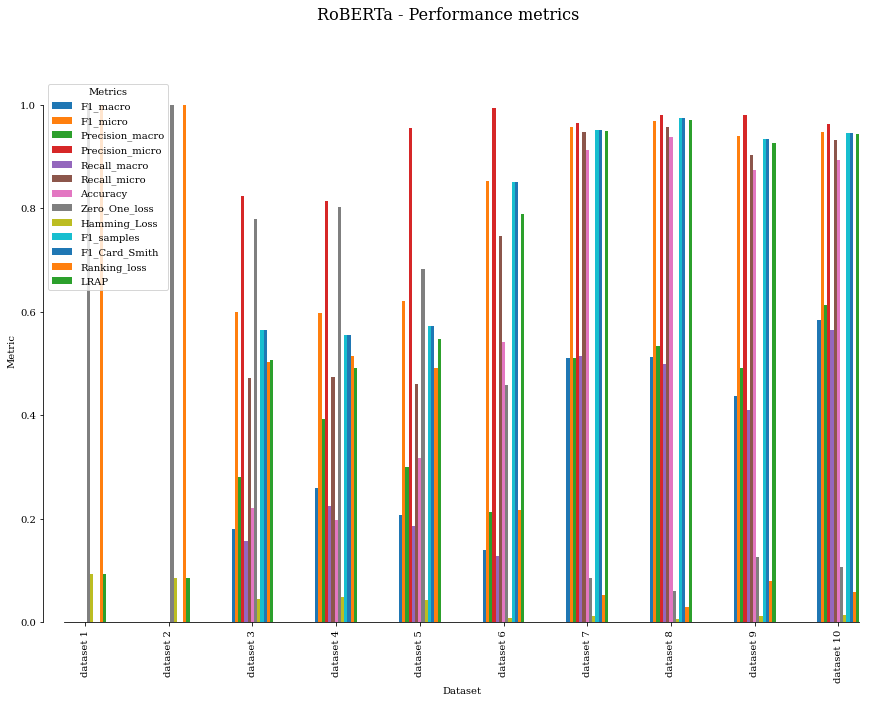

All changes made in this colab session should now be visible in Drive.
[RoBERTa-MLL]: Done running the model and saving the results!


In [6]:
# 3. setup preliminaries: Mount GoogleDrive, setup model, etc.
if IN_COLAB==True:
  # mount the google drive which has been prepared with the data for the task
  drive.mount('/content/drive')

  # generate the model storage folder paths for later model dumping
  model_storage_folders = []
  for index in range(1, 11):
    folder_base = '/content/drive/My Drive/ma_data/stored_models/roberta_mll/model_dataset_{}/'.format(index)
    model_storage_folders.append(folder_base)

  # switch on logging
  logname = '/content/drive/My Drive/ma_data/stored_models/roberta_mll/roberta_models_run.log'
  logging.basicConfig(filename=logname, 
                      level=logging.DEBUG, 
                      filemode='w')
  transformers_logger = logging.getLogger("transformers")


  # create dataset paths for fixed train/test splits
  data_parts_list = []
  for index in range(1, 11):
    # generate paths
    base_path='/content/drive/My Drive/ma_data/'
    x_trainp=base_path+"dataset{}_Xtrain.csv".format(index)
    x_testp=base_path+"dataset{}_Xtest.csv".format(index)
    y_trainp=base_path+"dataset{}_ytrain.csv".format(index)
    y_testp=base_path+"dataset{}_ytest.csv".format(index)
	  # add to list
    data_parts_list.append([x_trainp, x_testp, y_trainp, y_testp])

  # create the predictions storage path 
  pred_storage_path = '/content/drive/My Drive/ma_data/stored_models/roberta_mll/dumped_predictions/'

  # call the model for each dataset separately
  roberta_ds_metrics = []
  indexer = 0
  for filename_list in data_parts_list:
    # get the appropriate model storage folder path from model_storage_folders
    model_folder = model_storage_folders[indexer]
    print("[RoBERTa-MLL]: Saving model to: {} after fine-tuning!".format(model_folder))
    indexer += 1
    # setup the arguments dictionary for the model
    # parts from: https://github.com/pytorch/fairseq/blob/master/examples/roberta/README.glue.md
    roberta_model_config = {"output_dir": model_folder,
                            "cache_dir": model_folder,
                            "best_model_dir": model_folder,
                            "fp16": True,
                            "fp16_opt_level": "O1",
                            "max_seq_length": 128, # leave this for comp.
                            "train_batch_size": 8, # leave this for comp.
                            "eval_batch_size": 8, # leave this for comp.
                            "gradient_accumulation_steps": 1, # leave this for comp.
                            "num_train_epochs": 3, # overridden
                            "weight_decay": 0.1, # overridden
                            "learning_rate": 2e-05, # overridden GLUE
                            "adam_epsilon": 1e-06, # overridden GLUE
                            "warmup_ratio": 0.06, # overridden GLUE
                            "warmup_steps": 122, # overridden GLUE
                            "max_grad_norm": 1.0,
                            "do_lower_case": False,
                            "logging_steps": 50,
                            "evaluate_during_training": True, # overridden
                            "evaluate_during_training_steps": 2000,
                            "evaluate_during_training_verbose": True, # overridden
                            "use_cached_eval_features": False,
                            "save_eval_checkpoints": True, 
                            "save_steps": 2000,
                            "no_cache": False,
                            "save_model_every_epoch": True,
                            "tensorboard_dir": model_folder, # overridden
                            "overwrite_output_dir": True, # overrriden
                            "reprocess_input_data": True,
                            "process_count": cpu_count() - 2 if cpu_count() > 2 else 1,
                            "n_gpu": 1,
                            "silent": False,
                            "use_multiprocessing": True,
                            "wandb_project": None,
                            "wandb_kwargs": {},
                            "use_early_stopping": True,
                            "early_stopping_patience": 3,
                            "early_stopping_delta": 0.01, # overrridden
                            "early_stopping_metric": "eval_loss",
                            "early_stopping_metric_minimize": True,
                            "manual_seed": 2020 # overriden
                          }
    # fine tune model on the dataset, extract evaluation metrics from last
    # evaluation run and save these metrics 
    metrics_list = roberta_multilabel_classification(dataset_filenamelist = filename_list,
                                                     roberta_config = roberta_model_config,
                                                     dump_pred_path = pred_storage_path,
                                                     verbose = False)
    # for each dataset write a list into the overall metrics list 
    roberta_ds_metrics.append(metrics_list)
    print("Current metrics: {}".format(metrics_list))
  
  ####################### REPORTING OF RESULTS #################################
  print("[RoBERTa-MLL]: Generating the metrics report!")

  # generate the metrics dataset
  metrics_df = pd.DataFrame(roberta_ds_metrics)
  colnames = ['F1_macro', 'F1_micro', 'Precision_macro', 'Precision_micro', 
                'Recall_macro', 'Recall_micro', 'Accuracy', 'Zero_One_loss', 
                'Hamming_Loss', 'F1_samples', 'F1_Card_Smith', 
                'Ranking_loss', 'LRAP', 'Model_time']
  metrics_df.columns = colnames
  # insert dataset identifier
  metrics_df['Dataset_ID'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] 
  new_colnames = ['Dataset_ID', 'F1_macro', 'F1_micro', 'Precision_macro', 'Precision_micro', 
                'Recall_macro', 'Recall_micro', 'Accuracy', 'Zero_One_loss', 
                'Hamming_Loss', 'F1_samples', 'F1_Card_Smith', 
                'Ranking_loss', 'LRAP', 'Model_time']
  # reorder the dataset columns
  metrics_df = metrics_df[new_colnames]

  # store it on HDD
  metrics_file_path = '/content/drive/My Drive/ma_data/stored_metrics/RoBERTa_mll_metrics.csv'
  metrics_df.to_csv(metrics_file_path, index=False, header=True, encoding='utf-8')

  # store latex version on HDD
  print("[RoBERTa-MLL]: Trying to store the *.tex-file!")
  texmet_file_path = '/content/drive/My Drive/ma_data/stored_metrics/RoBERTa_mll_metrics.tex'
  try:
    metrics_df.to_latex(texmet_file_path, index=False)
  except:
    print("[RoBERTa-MLL]: Failed to print to latex!")

  # drop the dataset id column
  metrics_df = metrics_df.iloc[:, 1:]
  metrics_df = metrics_df.iloc[:, :-1]
  # plot the data 
  labels = ["dataset 1", "dataset 2", "dataset 3", "dataset 4", "dataset 5", 
            "dataset 6", "dataset 7", "dataset 8", "dataset 9", "dataset 10"]
  fig, ax = plt.subplots(figsize=(15, 10))
  metrics_df.plot.bar(ax=ax)
  # label and style the plot
  ax.set_ylabel('Metric')
  ax.set_xlabel('Dataset')
  fig.suptitle('RoBERTa - Performance metrics', fontsize=16)
  plt.rc('xtick', labelsize='x-small')
  plt.rc('ytick', labelsize='x-small')
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  # restyle left and bottom axis
  ax.spines['left'].set_smart_bounds(True)
  ax.spines['bottom'].set_smart_bounds(True)
  ax.legend(loc='best', title='Metrics')
  ax.set_xticklabels(labels)

  # store on HDD for documentation
  plot_path = '/content/drive/My Drive/ma_data/stored_plots/RoBERTa_mll_metrics.png'
  plt.savefig(plot_path)
  plt.show()

  ################# LAST BUT NOT LEAST - UNMOUNT #################################
  drive.flush_and_unmount()
  print('All changes made in this colab session should now be visible in Drive.')
  
  ########################## LAST STATUS MESSAGE ###############################
  print("[RoBERTa-MLL]: Done running the model and saving the results!")
else: 
  print("[RoBERTa-MLL]: No COLAB environment found - aborting!")